# DTSA 5511 Week 3 Project
### Introduction

For this project the target dataset is a set of images of histopathologic scans (tissue magnified via microscope) of lymph node sections, which may or may not contain metastatic tissue (cancer). The [dataset](https://www.kaggle.com/c/histopathologic-cancer-detection) is hosted via Kaggle, with the goal of identifying which images include metatstic tissue.

More specifically, per the data description on Kaggle: "A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image."

Convolutional Neural Network (CNN) based models will be trained towards this goal since they have been proven effective for image-based analysis tasks.

All code for this project can be found at my Github: https://github.com/nhansendev/DTSA5511_W3

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision.models import ShuffleNetV2
from torchsummary import summary
import gc

from constants import SCRIPT_DIR, RANDOM_SEED, RNG
# Multiple functions were moved to another file for brevity
import functions as F

# Draw grid in background
plt.rcParams['axes.axisbelow'] = True

torch.manual_seed(RANDOM_SEED);

### Initial Data Exploration and Cleaning

In [2]:
# Import Datasets
raw_labels = pd.read_csv(os.path.join(SCRIPT_DIR, "Datasets", "train_labels.csv"))
test_labels = pd.read_csv(os.path.join(SCRIPT_DIR, "Datasets", "test_labels.csv"))

train_data = np.load(os.path.join(SCRIPT_DIR, "Datasets", "train_0.npy"))
train_labels = np.load(os.path.join(SCRIPT_DIR, "Datasets", "train_labels_0.npy"))

print(train_data.shape)

print(len(test_labels), 'images in test set')
print(len(raw_labels), 'images in train set')

print(raw_labels.head())
values, counts = np.unique(raw_labels['label'], return_counts=True)
print('\nCancer Cells Present:', values)
print(counts)
print([f"{c/len(raw_labels):.1%}" for c in counts])

(220025, 3, 96, 96)
57458 images in test set
220025 images in train set
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Cancer Cells Present: [0 1]
[130908  89117]
['59.5%', '40.5%']


We can see that there are 220025 images in the training set and 57458 in the testing set, where each image has three color channels (RGB) and is 96x96 pixels. Additionally, label data for the training set is provided pairing image id (file name) with a label indicating whether cancerous tissue is present or not. The test labels are just the image ids without tumor information, which must be predicted.

In approximately 60% of the training dataset there are no tumors present. Since the split is not heavily imbalanced there will be no re-balancing during training.

Note that the separate image files have been pre-processed into single numpy arrays for training and testing sets, which are then saved to disk. This is much faster to read than retrieving the images separately, but has high RAM requirements.

Some example images, for reference (images with cancerous tissue present are bordered in red):

20


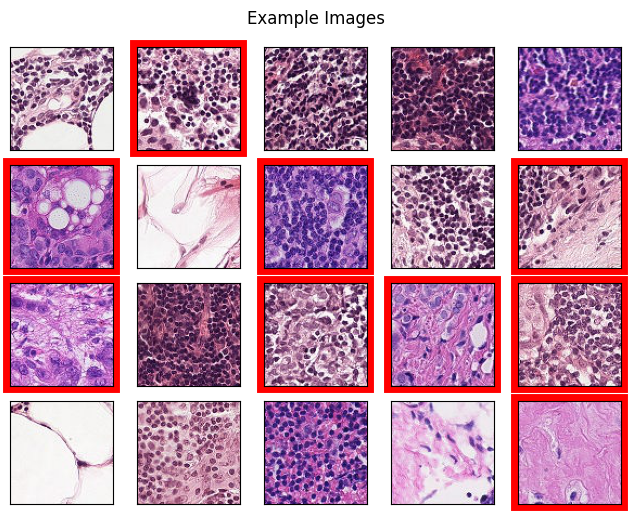

In [3]:
idxs = RNG.choice(np.arange(len(train_data)), size=20)
F.plot_images(idxs, train_data, train_labels, C=5, title='Example Images')

No obvious patterns present themselves to explain which samples contain the cancerous tissue, highlighting the need for analysis by trained professionals and the potential usefulness of well-trained models.

### Check Image Quality
Some images may be too light, dark, or uniform for features to be clearly distinguished, which means they would not be useful for training. To detect these images the grayscale brightness and standard deviation of each image can be calculated and compared:

In [4]:
# For each image, get the mean and std dev grayscale brightness
brightness = np.mean(train_data, (3, 2, 1))
b_std = np.std(train_data, (3, 2, 1))

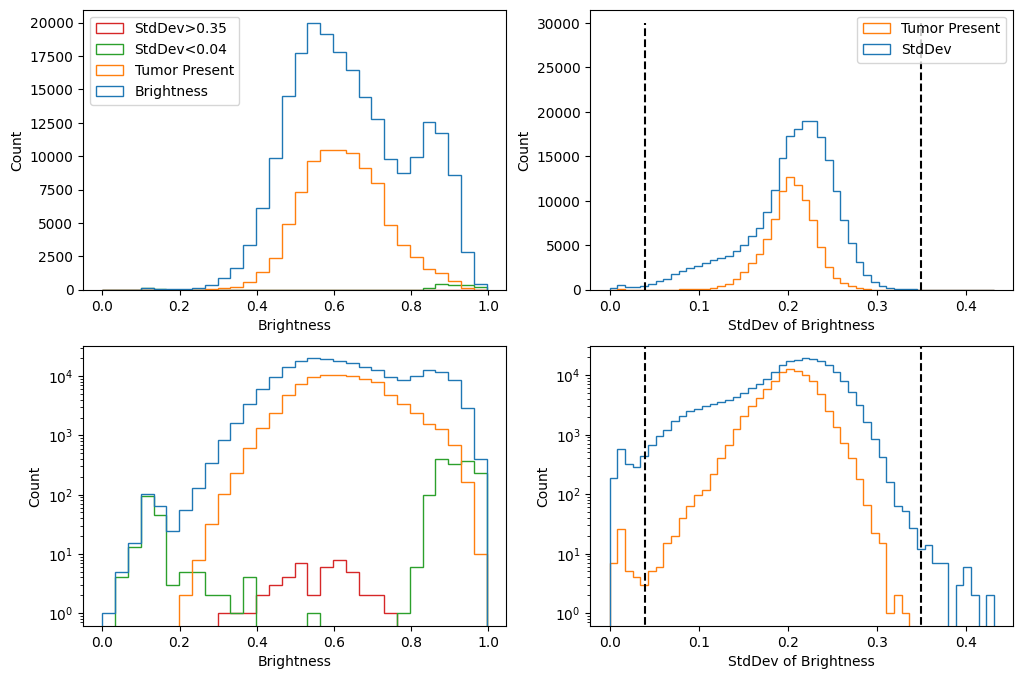

In [5]:
# Set thresholds for low and high brightness standard deviation
std_thr_L = 0.04
std_thr_H = 0.35

F.plot_brightness(brightness, b_std, train_labels, std_thr_L, std_thr_H)

The histograms show an intuitive result when comparing low values of the standard deviation of brightness (SD) against mean brightness: very high and very low values of brightness tend to have low SD. Interestingly, for images below a certain brightness threshold there are no instances of tumors, suggesting that the medical professionals doing the labeling were unable to distinguish useful features for tumor recognition. Alternative explanations do exist, such as a correlation between dark tissue samples and tumor resistance, but the initial explanation seems the simplest and most likely. Additionally, for high SD values there is a threshold beyond which no tumors are reported. This may indicate that there is something wrong with the images, since large variations in brightness would be required for high SDs.

Additionally, there are multiple images that have high brightness and low SD, but are still labeled with tumors. This may indicate that a small patch of cancerous tissue is present in an otherwise "blank" image, which is in-line with the expectations for the dataset (images with even a single pixel of cancer in the center 32x32 pixels are labeled as containing cancer).

Investigating the images with high standard deviations:

45


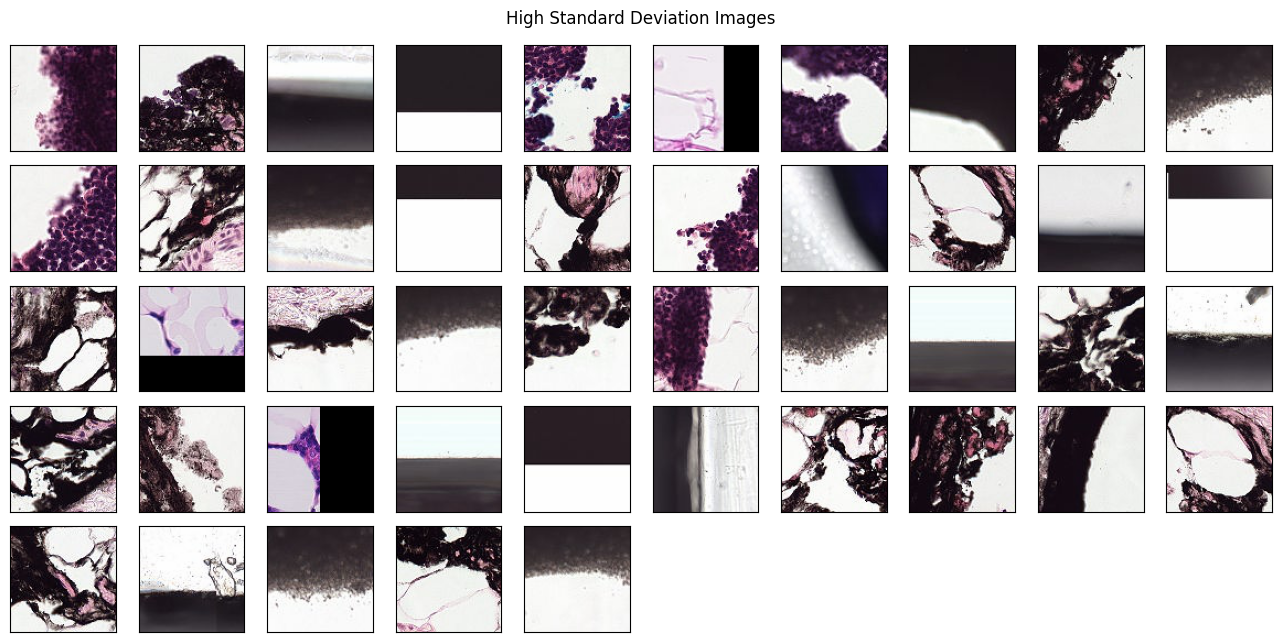

In [6]:
idxs = b_std > std_thr_H
F.plot_images(idxs, train_data, train_labels, title='High Standard Deviation Images')

There are only 45 images above the chosen SD threshold, all of which have been plotted. It's immediately apparent that the quality of these images is low, with many demonstrating cut-off, or out of focus regions. Since this represents a small fraction of the dataset these images will simply be dropped.

Looking at the images with low brightness and low SD:

163


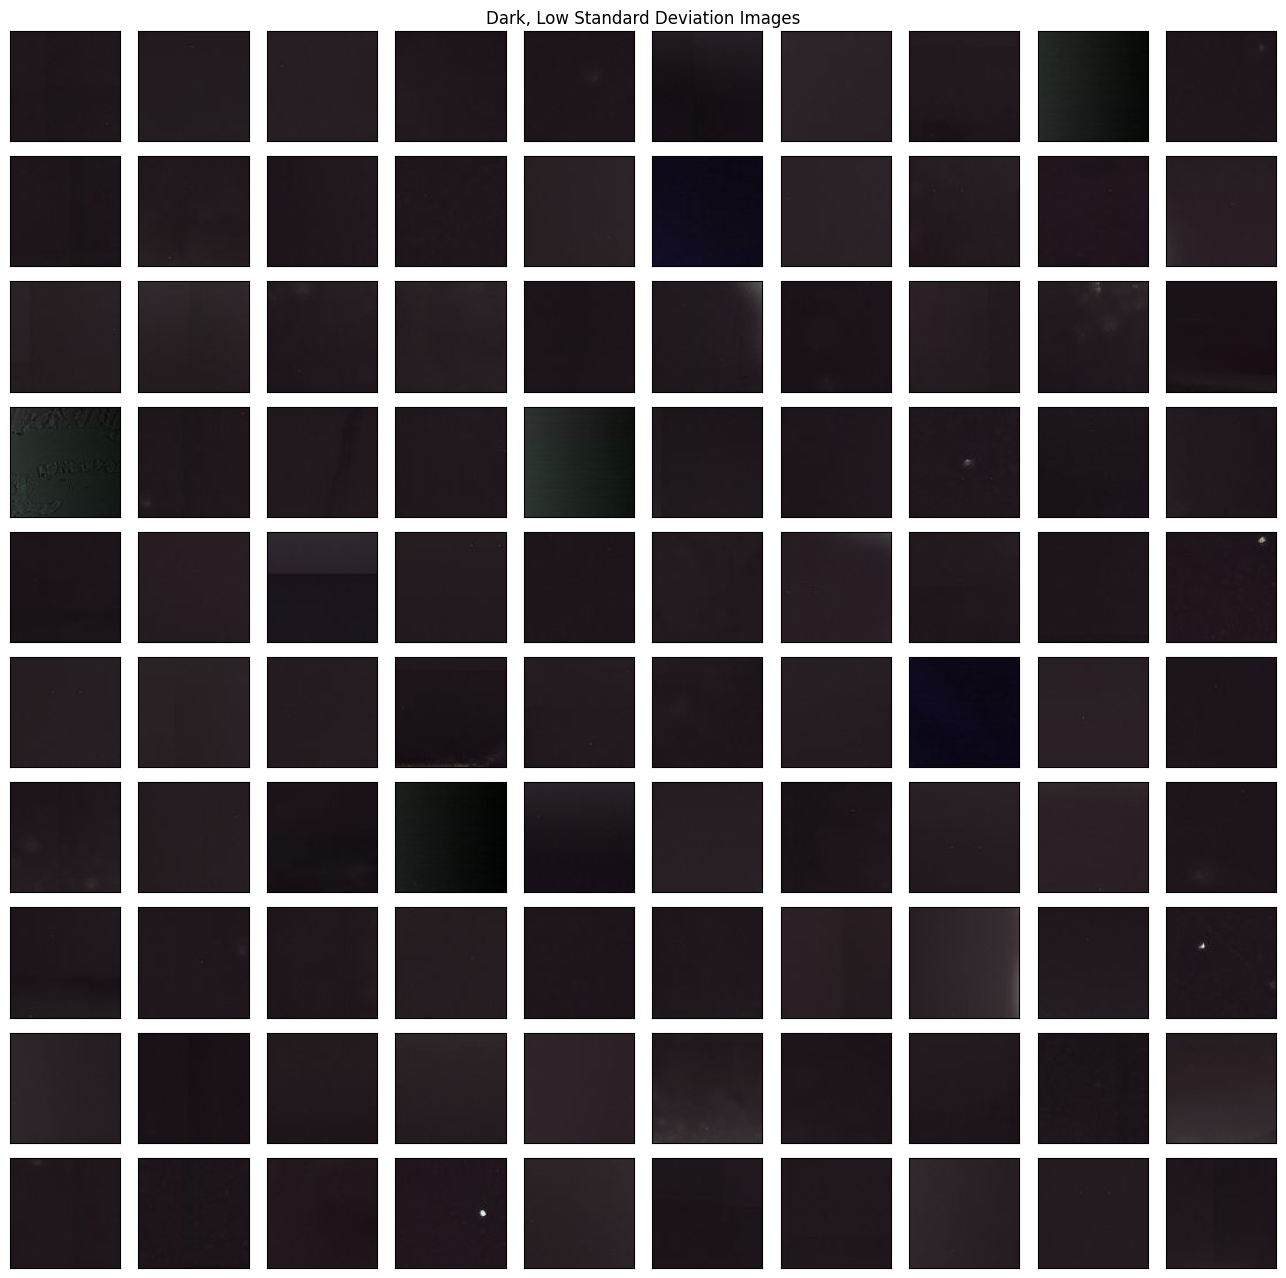

In [7]:
idxs = np.logical_and(b_std < std_thr_L, brightness < 0.2)
F.plot_images(idxs, train_data, train_labels, title='Dark, Low Standard Deviation Images')

There are 163 images below the chosen thresholds, with 100 of them plotted. As expected, the images are almost entirely lacking in brightness variations, with virtually no discernable features. Since there is no useful information for training and these are a small portion of the dataset they will also be dropped.

The images with low SD and high brightness are plotted next:

44


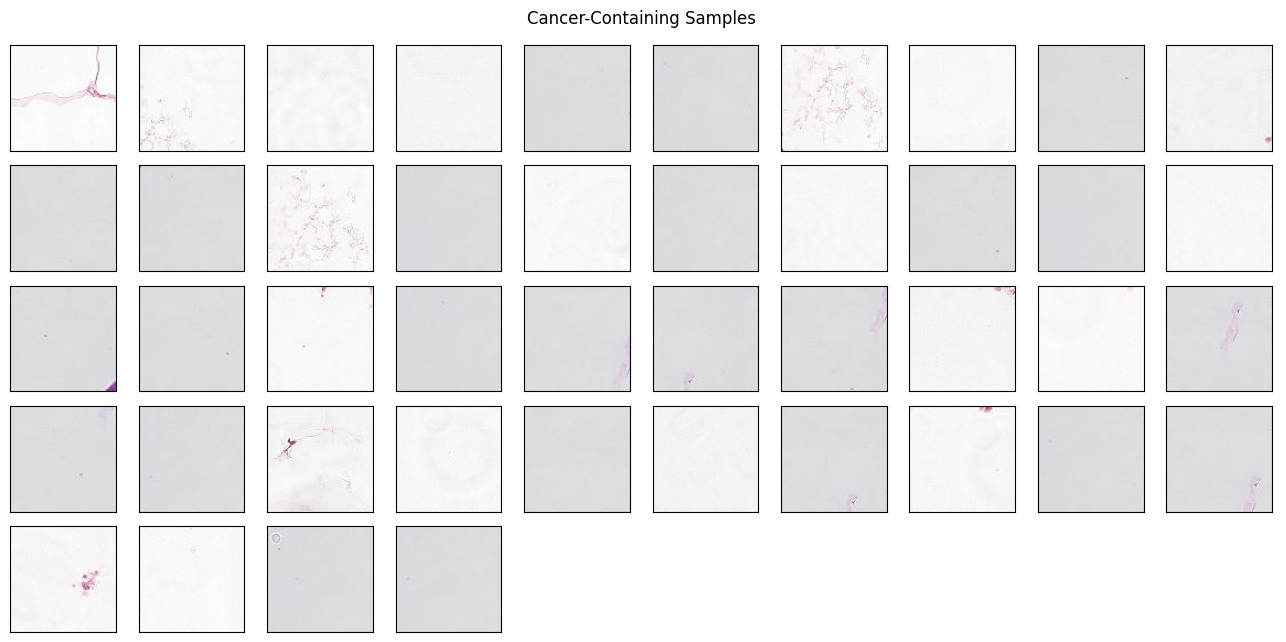

1386


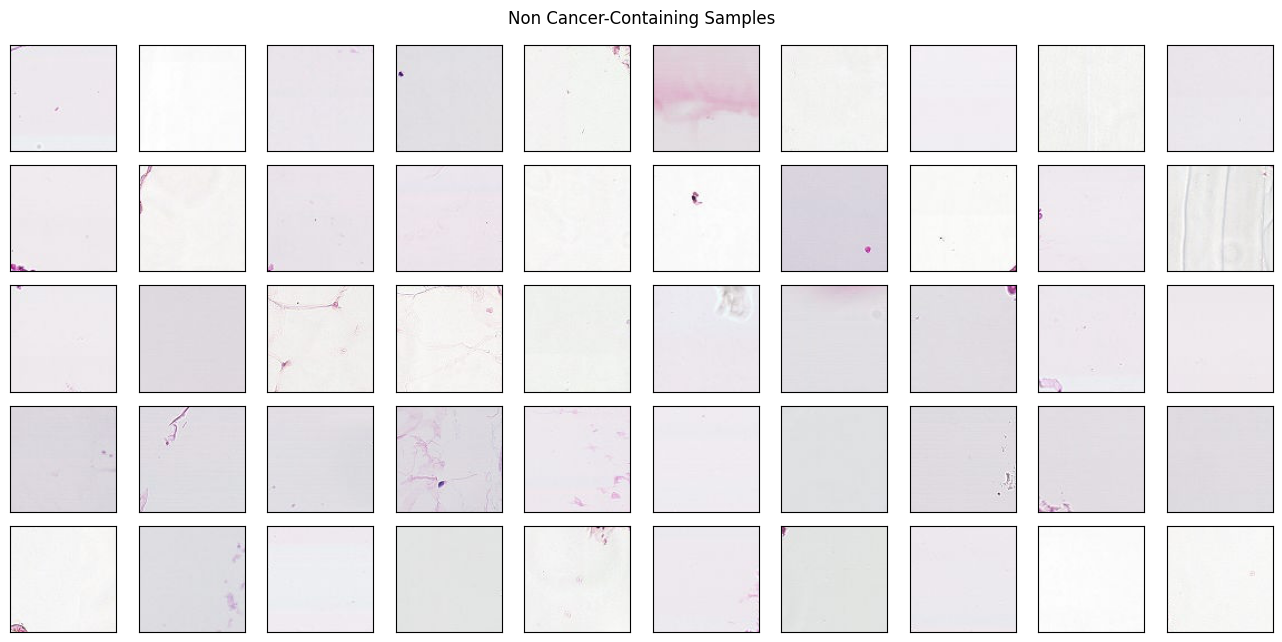

In [8]:
# Plot examples of high brightness, low SD images with tumors
idxs = np.logical_and(train_labels>0, np.logical_and(b_std < std_thr_L, brightness > 0.8))
F.plot_images(idxs, train_data, train_labels, title="Cancer-Containing Samples", highlights=False)

# Plot examples of high brightness, low SD images without tumors
idxs = np.logical_and(train_labels<1, np.logical_and(b_std < std_thr_L, brightness > 0.8))
F.plot_images(idxs, train_data, train_labels, title="Non Cancer-Containing Samples", lim=50)

Out of 1430 images within the SD and brightness criteria only 44 are labeled for tumors (all of which are plotted). As mentioned earlier, even a single pixel of tumor is sufficient to gain the label, so dispite the "blankness" of the images they can't simply be discarded.

In [9]:
# Remove low quality images
idxs = np.invert(np.logical_or(b_std > std_thr_H, np.logical_and(b_std < std_thr_L, brightness < 0.2)))
print(f'{len(train_data)} -> {np.sum(idxs)} ({np.sum(idxs)/len(train_data)-1:.2%})')
train_data = train_data[idxs]
train_labels = train_labels[idxs]

220025 -> 219817 (-0.09%)


Removing the few low-quality images had a minimal impact on the size of the dataset.

### Model Training

Four configurations will be compared during training:
1. A simple Convolutional Network (ConvNet)
2. ConvNet with data augmentations
3. [ShuffleNetV2](https://pytorch.org/vision/main/models/shufflenetv2.html), not pre-trained
4. Transfer learning using ShuffleNetV2 pre-trained on ImageNet1k

This will help us select an appropriate architecture and evaluate both data augmentation and transfer learning.

When image augmentations are used they include the following transformations and are randomly applied, in random combinations:
- Horizontal Flip
- Vertical Flip
- Rotation (0 to 10 degrees)
- Resized Crop (up to 10% smaller, then rescaled to original image size)
- Color Jitter (shift the color balance of the image)

The augmentations will be applied on every-other training step, when used.

In each case the Adam optimizer (a good general-purpose optimizer) will be used, with the training duration set to 6000 optimizer steps. The learning rate will be varied using the CosineAnnealingWarmRestarts scheduler, which repeatedly decreases, then resets the learning rate. In theory, this can help "jostle" the parameters out of local minima during the restarts while still making overall progress.

Binary Cross Entropy is used as the loss function due to the binary nature of the problem (cancer present or not).

In [10]:
# Split data for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    train_data, train_labels, test_size=4096, random_state=RANDOM_SEED
)

# To save memory, remove the pre-split data
del train_data
del train_labels

# Some tensors will be re-used frequently and can just sit on the GPU
label_tensor = torch.FloatTensor(y_train).cuda()
Xvalid_tensor = torch.FloatTensor(X_valid).cuda()

# For model summaries
dummy_tensor = torch.ones(1, 3, 96, 96)
dummy_tensor.cuda();

# Load the data for testing
test_data = torch.FloatTensor(np.load(os.path.join(SCRIPT_DIR, "Datasets", "test_0.npy")))

In [11]:
def run_model_test(model, name, test_batch=1024):
    # Split predictions into batches to fit into GPU memory
    preds = []
    for batch in range(int(np.ceil(len(test_data)/test_batch))):
        preds.extend((nn.functional.sigmoid(model(test_data[test_batch*batch:test_batch*(batch+1)].cuda())) > 0.5).int().flatten().tolist())

    # Save to file
    test_labels['label'] = preds
    test_labels.to_csv(os.path.join(SCRIPT_DIR, name), index=False)

### ConvNet (no augmentations)
As shown by the summary below, the ConvNet is composed of layers of 2-D Convolutions, SiLU activations, dropout layers, and Max Pooling layers, followed by Linear layers to adapt to the required output size (one value).

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 20, 94, 94]          560
|    └─Conv2d: 2-2                       [-1, 20, 92, 92]          3,620
|    └─SiLU: 2-3                         [-1, 20, 92, 92]          --
|    └─Dropout2d: 2-4                    [-1, 20, 92, 92]          --
|    └─MaxPool2d: 2-5                    [-1, 20, 46, 46]          --
|    └─Conv2d: 2-6                       [-1, 20, 44, 44]          3,620
|    └─Conv2d: 2-7                       [-1, 20, 42, 42]          3,620
|    └─SiLU: 2-8                         [-1, 20, 42, 42]          --
|    └─Dropout2d: 2-9                    [-1, 20, 42, 42]          --
|    └─AdaptiveAvgPool2d: 2-10           [-1, 20, 2, 2]            --
|    └─Flatten: 2-11                     [-1, 80]                  --
|    └─Linear: 2-12                      [-1, 30]                  2,430
| 

100%|██████████| 6000/6000 [16:21<00:00,  6.11it/s]


Best Accuracy: 0.83
Best F1 Score: 0.79


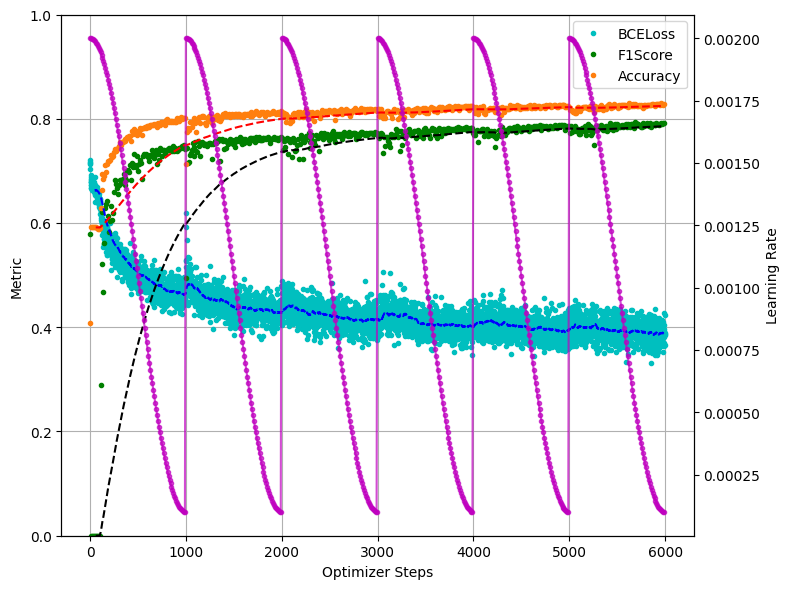

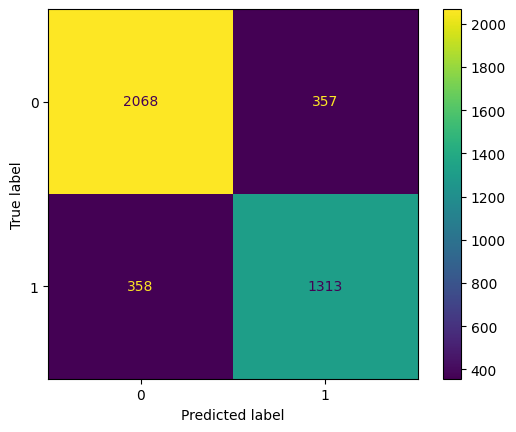

In [39]:
# Model Setup
model = F.ConvNet()
model.cuda() # send to GPU
summary(model, dummy_tensor)

F.train_model(model, X_train, label_tensor, Xvalid_tensor, y_valid, epochs=6000)

# Generate a file of predictions using the trained model and testing data
run_model_test(model, 'model_pred_0.csv')

# Cleanup GPU memory
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### ConvNet (with augmentations)
The same model is used, but every-other step includes random data augmentations.

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 20, 94, 94]          560
|    └─Conv2d: 2-2                       [-1, 20, 92, 92]          3,620
|    └─SiLU: 2-3                         [-1, 20, 92, 92]          --
|    └─Dropout2d: 2-4                    [-1, 20, 92, 92]          --
|    └─MaxPool2d: 2-5                    [-1, 20, 46, 46]          --
|    └─Conv2d: 2-6                       [-1, 20, 44, 44]          3,620
|    └─Conv2d: 2-7                       [-1, 20, 42, 42]          3,620
|    └─SiLU: 2-8                         [-1, 20, 42, 42]          --
|    └─Dropout2d: 2-9                    [-1, 20, 42, 42]          --
|    └─AdaptiveAvgPool2d: 2-10           [-1, 20, 2, 2]            --
|    └─Flatten: 2-11                     [-1, 80]                  --
|    └─Linear: 2-12                      [-1, 30]                  2,430
| 

100%|██████████| 3000/3000 [16:23<00:00,  3.05it/s]

Best Accuracy: 0.80
Best F1 Score: 0.76


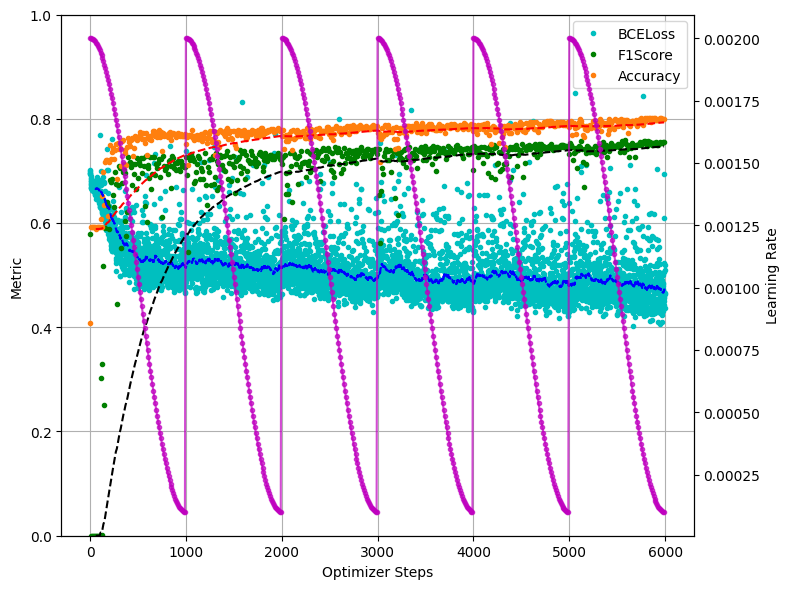

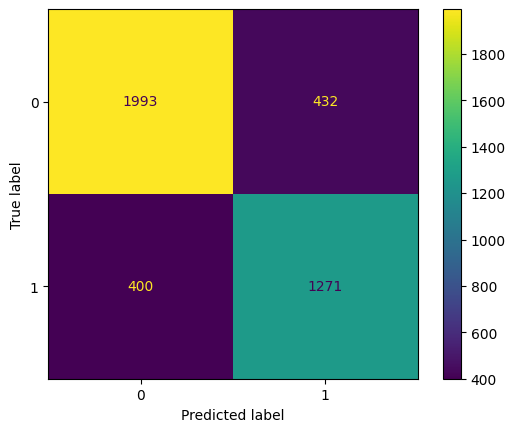

In [40]:
# Model Setup
model = F.ConvNet()
model.cuda()
summary(model, dummy_tensor)

F.train_model(model, X_train, label_tensor, Xvalid_tensor, y_valid, epochs=6000, augmented=True)

run_model_test(model, 'model_pred_1.csv')

# Cleanup
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

The training process is much noisier than before, with slower overall progress. 

### ShuffleNetV2 (no pre-training)
The structure of ShuffleNetV2 is much more complex then the ConvNet and includes both Batch Normalization and residuals.

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 48, 48]          --
|    └─Conv2d: 2-1                       [-1, 24, 48, 48]          648
|    └─BatchNorm2d: 2-2                  [-1, 24, 48, 48]          48
|    └─ReLU: 2-3                         [-1, 24, 48, 48]          --
├─MaxPool2d: 1-2                         [-1, 24, 24, 24]          --
├─Sequential: 1-3                        [-1, 48, 12, 12]          --
|    └─InvertedResidual: 2-4             [-1, 48, 12, 12]          --
|    |    └─Sequential: 3-1              [-1, 24, 12, 12]          888
|    |    └─Sequential: 3-2              [-1, 24, 12, 12]          1,512
|    └─InvertedResidual: 2-5             [-1, 48, 12, 12]          --
|    |    └─Sequential: 3-3              [-1, 24, 12, 12]          1,512
|    └─InvertedResidual: 2-6             [-1, 48, 12, 12]          --
|    |    └─Sequential: 3-4              [-1, 24, 12, 12]          1,512
|   

100%|██████████| 6000/6000 [07:45<00:00, 12.90it/s]


Best Accuracy: 0.83
Best F1 Score: 0.79


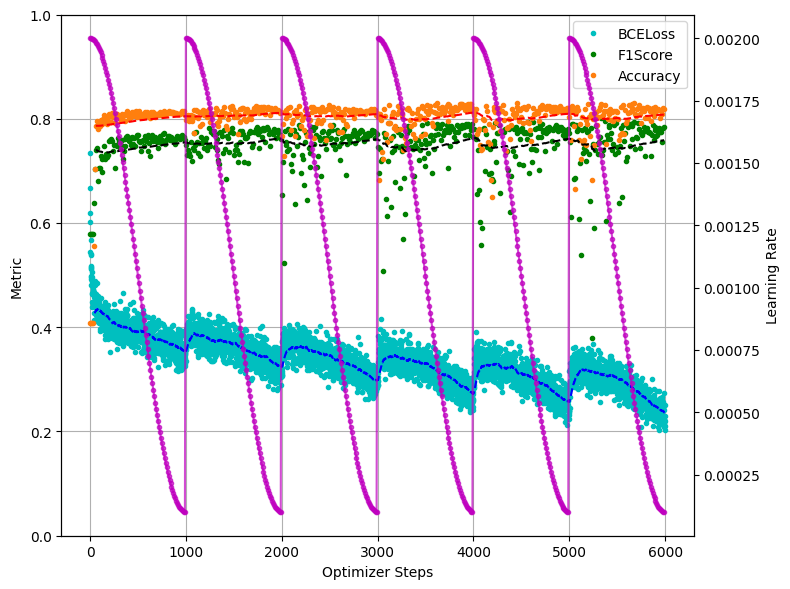

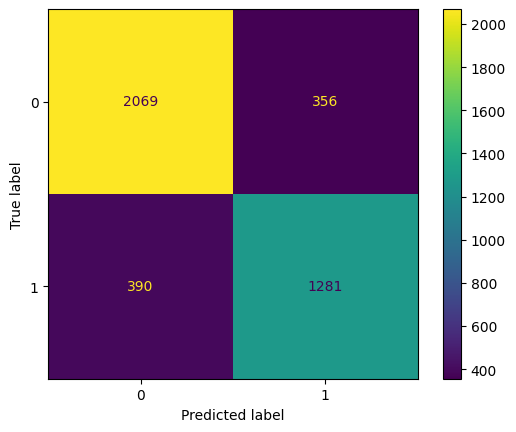

In [41]:
# Model Setup
model = ShuffleNetV2([4, 8, 4], [24, 48, 96, 192, 1024], num_classes=1)
model.cuda() # move to GPU
summary(model, dummy_tensor)

F.train_model(model, X_train, label_tensor, Xvalid_tensor, y_valid, epochs=6000)

run_model_test(model, 'model_pred_2.csv')

# Cleanup
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

The model training progress was faster than the ConvNet models, but looks more sensitive to the high learning rates upon restarts.

### ShuffleNetV2 (Pretrained on ImageNet1k)
Here transfer learning will be used to adapt a pre-trained model's feature extraction capabilities to our dataset. Additional linear layers were added to the output of the model to adapt its 1000 potential classes to our single classification.

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1]                   --
|    └─ShuffleNetV2: 2-1                      [-1, 1000]                --
|    |    └─Sequential: 3-1                   [-1, 24, 48, 48]          696
|    |    └─MaxPool2d: 3-2                    [-1, 24, 24, 24]          --
|    |    └─Sequential: 3-3                   [-1, 48, 12, 12]          6,936
|    |    └─Sequential: 3-4                   [-1, 96, 6, 6]            45,552
|    |    └─Sequential: 3-5                   [-1, 192, 3, 3]           89,952
|    |    └─Sequential: 3-6                   [-1, 1024, 3, 3]          198,656
|    |    └─Linear: 3-7                       [-1, 1000]                1,025,000
|    └─ReLU: 2-2                              [-1, 1000]                --
|    └─Linear: 2-3                            [-1, 1]                   1,001
Total params: 1,367,793
Trainable params: 1,367,793
Non-trainable pa

100%|██████████| 6000/6000 [07:39<00:00, 13.06it/s]


Best Accuracy: 0.86
Best F1 Score: 0.83


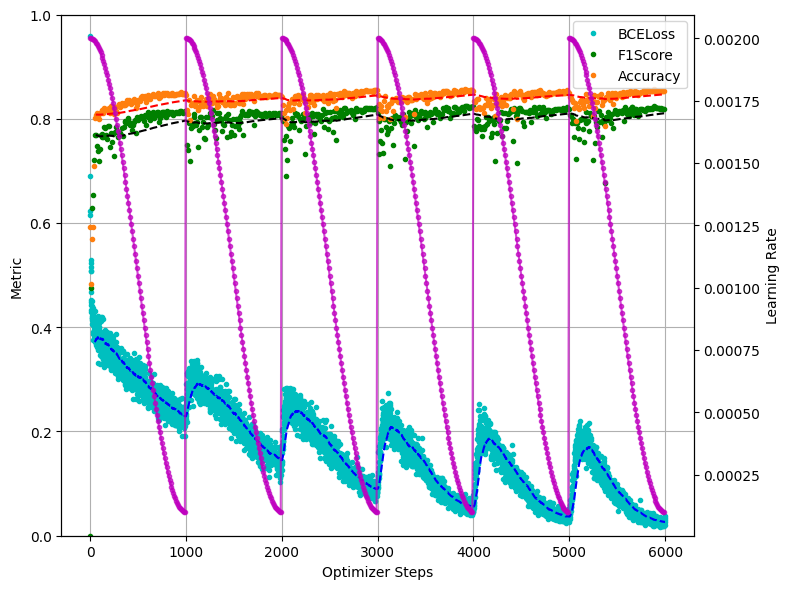

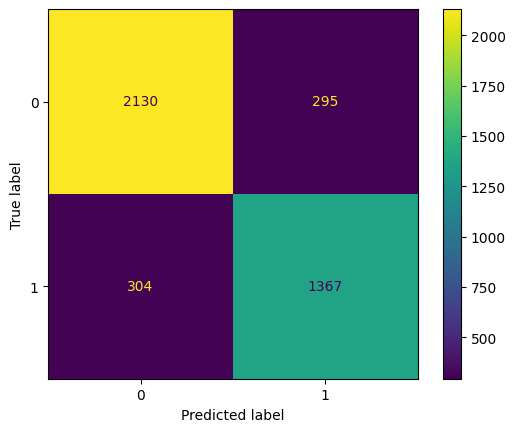

In [42]:
# Model Setup
model = F.TransferNet()
model.cuda() # move to GPU
summary(model, dummy_tensor)

F.train_model(model, X_train, label_tensor, Xvalid_tensor, y_valid, epochs=6000)

run_model_test(model, 'model_pred_3.csv')

# Cleanup
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

This model demonstrated the most rapid learning rates, with the lowest final loss.

### Basic Ensembling
Combinations of model predictions were used to create ensemble predictions via majority-votes:

In [53]:
p0 = pd.read_csv(os.path.join(SCRIPT_DIR, 'model_pred_0.csv'))
p1 = pd.read_csv(os.path.join(SCRIPT_DIR, 'model_pred_1.csv'))
p2 = pd.read_csv(os.path.join(SCRIPT_DIR, 'model_pred_2.csv'))
p3 = pd.read_csv(os.path.join(SCRIPT_DIR, 'model_pred_3.csv'))

# Make predictions with the first two models (majority vote)
ensemble_pred = ((p0['label'] + p1['label'])/2 > 0.5).astype(int)
p0['label'] = ensemble_pred
p0.to_csv(os.path.join(SCRIPT_DIR, 'ensemble_pred_x2.csv'), index=False)

# Make predictions with all four models (majority vote)
ensemble_pred = ((p0['label'] + p1['label'] + p2['label'] + p3['label'])/4 > 0.5).astype(int)
p0['label'] = ensemble_pred
p0.to_csv(os.path.join(SCRIPT_DIR, 'ensemble_pred_x4.csv'), index=False)

### Results
After gathering the test predictions for each model they were uploaded to Kaggle for judging, with the resulting scores entered into the table below:

In [54]:
header = ['Model Name', 'Model Params', 'Best Acc', 'Best F1', 'Train Time (s)', 'Test Score']
data = [['ConvNet', 14171, 0.82, 0.78, 1194, 0.8073],
        ['ConvNet-Aug', 14171, 0.81, 0.76, 2182, 0.7993],
        ['ShuffleNetV2', 342817, 0.84, 0.8, 452, 0.7765],
        ['ShuffleNetV2-Transfer', 1367793, 0.85, 0.83, 466, 0.7689],
        ['Ensemble of 2', '-', '-', '-', '-', 0.8021],
        ['Ensemble of 4', '-', '-', '-', '-', 0.7988]]

pd.DataFrame(data, columns=header)

,Model Name,Model Params,Best Acc,Best F1,Train Time (s),Test Score
0,ConvNet,14171,0.82,0.78,1194,0.8073
1,ConvNet-Aug,14171,0.81,0.76,2182,0.7993
2,ShuffleNetV2,342817,0.84,0.8,452,0.7765
3,ShuffleNetV2-Transfer,1367793,0.85,0.83,466,0.7689
4,Ensemble of 2,-,-,-,-,0.8021
5,Ensemble of 4,-,-,-,-,0.7988


The results of each model's training and evaluations are shown in the table above. Two additional "Ensemble" entries were created by using the majority votes of the model predictions for the test data. The "Ensemble of Two" used the two ConvNets' predictions with the "Ensemble of Four" used all four models.

From the table we can see that the best performing model during training was the ShuffleNetV2 with transfer learning, which was also very fast to train despite having the most parameters (roughly 100x more than the smallest models). This is not a coincidence, since ShuffleNetV2 was designed to maximize efficiency, with the authors optimizing its structure based on the execution time and space complexity of different operations.

However, when comparing each model's test scores we can see that the basic ConvNet **without** augmentations performed the best. The ConvNet **with** augmentations took longer to train (approx. 2x) due to generating new augmentations at every-other step, and had slightly lower performance metrics. Since the augmentations constantly introduced "new" data that the network would need to adapt to it makes sense that its training progress was slower. Both ShuffleNetV2s performed worse in testing, demonstrating that the larger models over-fit to the data. Additionally, attempting to ensemble the model predictions did not improve upon the best individual score in either case.

Based on the plots of training metrics the models may have achieved higher scores with more iterations, but given the evidence of over-fitting it may be better to first reduce model sizes.

When comparing the validation data confusion matrices we can see that each model had a roughly even split between false-positives and false-negatives. Since the goal is related to cancer detection we actually prefer to have false-positives over false-negatives, since a false-positive would likely just result in additional screening of a healthy patient while a false-negative would miss a patient with cancer.

### Conclusion
The goal of this project was to create Convolutional Neural Network (CNN) based models capable of predicting which images of tissue samples contained cancerous cells. 

Four models were trained for this goal, with each scoring between 76% - 81% accuracy during testing, with the results likely suffering from over-fitting. Basic ensembling was attempted, but did not improve upon the best individual score.


Potential future areas of exploration:
- The dataset could be clustered, then an ensembling method used to specialize models on different "types" of images
- Additional regularization methods and smaller models may help reduce over-fitting
- Different learning rate schedulers, or even a constant learning rate may be a better fit
- A preference for false-positives over false-negatives could be included in the loss evaluation

Github link: https://github.com/nhansendev/DTSA5511_W3

### References

- Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection

- ShuffleNet V2 — Torchvision main documentation. (n.d.). Retrieved August 13, 2024, from https://pytorch.org/vision/main/models/shufflenetv2.html

- Ma, N., Zhang, X., Zheng, H., & Sun, J. (2018, July 30). ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design. arXiv.org. https://arxiv.org/abs/1807.11164

- CosineAnnealingWarmRestarts — PyTorch 2.4 documentation. (n.d.). https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html#torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
